# Income Qualification Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

In [2]:
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')
train_dataset.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
# Dataset Shapes
print('Income Qualification training dataset shape:', train_dataset.shape)
print('Income Qualification testing dataset shape:', test_dataset.shape)

Income Qualification training dataset shape: (9557, 143)
Income Qualification testing dataset shape: (23856, 142)


### Q1. Identify the output variable

In [4]:
for column in train_dataset.columns:
    if column not in test_dataset.columns:
            print('Target Column:', column)

Target Column: Target


#### Target Column

The target column contains integer values between 1 to 4 and the distribution of the sample is unbalanced. We have way more '4's than '1's. Unbalanced datasets are a challenge to the machine learning models

In [5]:
train_dataset['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

### Q2. Understand the type of data.

In [6]:
train_dataset.dtypes.value_counts()

int64      130
float64      8
object       5
dtype: int64

#### The training dataset contains 130 integer type columns, 8 floating point type and 5 object type. Let us first look at the object type and floating point

#### Float Type Columns

In [7]:
#Floating point columns

float_df = train_dataset.select_dtypes(include=['float64'])
float_df.head()

,v2a1,v18q1,rez_esc,meaneduc,overcrowding,SQBovercrowding,SQBdependency,SQBmeaned
0,190000.0,NaN,NaN,10.0,1.000000,1.000000,0.0,100.0
1,135000.0,1.0,NaN,12.0,1.000000,1.000000,64.0,144.0
2,NaN,NaN,NaN,11.0,0.500000,0.250000,64.0,121.0
3,180000.0,1.0,1.0,11.0,1.333333,1.777778,1.0,121.0
4,180000.0,1.0,NaN,11.0,1.333333,1.777778,1.0,121.0


#### Float type Column Description:

* <b>'v2a1'</b>: Monthly rent payment
<br>
*<b>'v18q1'</b>: Number of tablets household owns
<br>
*<b>'rez_esc'</b>: Years behind in school
<br>
*<b>'meaneduc'</b>: Average years of education for adults (18+)
<br>
*<b>'overcrowding'</b>: # persons per room
<br>
*<b>'SQBovercrowding'</b>: overcrowding squared
<br>
*<b>'SQBdependency'</b>: dependency squared
<br>
*<b>'SQBmeaned'</b>: square of the mean years of education of adults (>=18) in the
household



#### Object Type Columns

In [8]:
object_df = train_dataset.select_dtypes(include=['object'])
print(object_df.columns)
object_df.head(5)

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')


,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


#### Object Type column Decription

* <b>'dependency'</b>: Monthly rent payment
<br>
*<b>'edjefe'</b>: years of education of male head of household, based on the interaction of
escolari (years of education), head of household and gender, yes=1 and no=0
<br>
*<b>'edjefa'</b>: years of education of female head of household, based on the interaction of
escolari (years of education), head of household and gender, yes=1 and no=0
<br>
*<b>'Id'</b>: This column identifies each individual uniquely
<br>
*<b>'idhogar'</b>: This column identifies each household uniquely and this will be used for analysis based on household level

In [9]:
# count of members in each household
household = train_dataset['idhogar'].value_counts()
household = household.rename_axis('idhogar').reset_index(name='MemberCount')
household.head()

,idhogar,MemberCount
0,fd8a6d014,13
1,0c7436de6,12
2,ae6cf0558,12
3,6b35cdcf0,11
4,4476ccd4c,11


Grouping the data based on the number of members in the household. For e.g There is only one family with 13 members

In [10]:
household['MemberCount'].value_counts()

3     755
2     688
4     609
1     398
5     315
6     136
7      52
8      12
9      10
10      6
11      4
12      2
13      1
Name: MemberCount, dtype: int64

#### Treating 'edjefe' & 'edjefa' columns

In [11]:
train_dataset['edjefe'].value_counts()

no     3762
6      1845
11      751
9       486
3       307
15      285
8       257
7       234
5       222
14      208
17      202
2       194
4       137
16      134
yes     123
12      113
10      111
13      103
21       43
18       19
19       14
20        7
Name: edjefe, dtype: int64

Mapping 'no' with 0 and yes

In [12]:
train_dataset['edjefe'][(train_dataset['edjefe'] =='no') | (train_dataset['edjefe'] =='yes')].value_counts().sort_index()

no     3762
yes     123
Name: edjefe, dtype: int64

In [13]:
train_dataset['edjefe'].replace({'no':0, 'yes':1},inplace=True)
train_dataset['edjefe'][(train_dataset['edjefe'] =='no') | (train_dataset['edjefe'] =='yes')].value_counts().sort_index()

Series([], Name: edjefe, dtype: int64)

In [14]:
#Replacing 'edjefa' column's values
print('Before Replacing',train_dataset['edjefa'][(train_dataset['edjefa'] =='no') | (train_dataset['edjefa'] =='yes')]
      .value_counts().sort_index())
train_dataset['edjefa'].replace({'no':0, 'yes':1},inplace=True)
print('after replace:',train_dataset['edjefa'][(train_dataset['edjefa'] =='no') | (train_dataset['edjefa'] =='yes')]
      .value_counts().sort_index())

Before Replacing no     6230
yes      69
Name: edjefa, dtype: int64
after replace: Series([], Name: edjefa, dtype: int64)


In [15]:
train_dataset['dependency'].value_counts()

yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
1.3333334      84
.40000001      84
2.5            77
5              24
3.5            18
1.25           18
.80000001      18
2.25           13
.71428573      12
1.75           11
1.2            11
.22222222      11
.83333331      11
.2857143        9
1.6666666       8
.60000002       8
.16666667       7
6               7
Name: dependency, dtype: int64

####  Dependency Column 'Yes' & 'no' value interpretation
The 'SQBdependency' which is simply the square of Dependancy seems to suggest that providers of the data assumed that 'no' == 0 and 'yes' == 1. Hence we can replace the 'yes' with 1 & 'no' with a 0.

We could also do a SQRT(SQBDependany) in order to get the Dependancy value

In [16]:
# SQBDependency distribution based on Dependency 'yes' & 'no'
train_dataset['SQBdependency'][(train_dataset['dependency']=='yes')|(train_dataset['dependency']=='no') ].value_counts()

1.0    2192
0.0    1747
Name: SQBdependency, dtype: int64

In [17]:
print('Before Replacing\n',train_dataset['dependency'][(train_dataset['dependency'] =='no') | (train_dataset['dependency'] =='yes')]
      .value_counts().sort_index())
train_dataset['dependency'].replace({'no':0, 'yes':1},inplace=True)
print('After Replacing\n',train_dataset['dependency'][(train_dataset['dependency'] =='no') | (train_dataset['dependency'] =='yes')]
      .value_counts().sort_index())

Before Replacing
 no     1747
yes    2192
Name: dependency, dtype: int64
After Replacing
 Series([], Name: dependency, dtype: int64)


#### Q7. % of NaN Values per Column

In [18]:
train_nan = pd.DataFrame(train_dataset.isnull().sum()).rename(columns={0:'total'})
train_nan['NaN_Percent'] = round(100*(train_nan['total']/train_dataset.shape[0]),2)
train_nan.sort_values('NaN_Percent',ascending= False ).head(6)

,total,NaN_Percent
rez_esc,7928,82.95
v18q1,7342,76.82
v2a1,6860,71.78
SQBmeaned,5,0.05
meaneduc,5,0.05
Id,0,0.00


Text(0.5, 1.0, 'Fraction Of NaN Values,%')

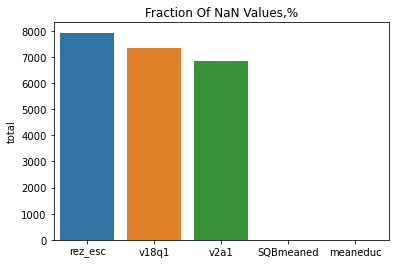

In [19]:
# Taking top 5 columns that have the null values
plot_copy = train_nan.sort_values('NaN_Percent',ascending= False ).head(5)
sns.barplot(y=plot_copy['total'],x=plot_copy.index)
plt.title('Fraction Of NaN Values,%')

#### The above analysis shows that the below columns have significant % of null values. We will treat each one of them in the upcoming steps:

* <b>'v2a1'[total nulls : 6860]</b>: Monthly rent payment
<br>
*<b>'v18q1'[total nulls : 7342]</b>: Number of tablets household owns 
<br>
*<b>'rez_esc'[total nulls : 7928]</b>: Years behind in school
<br>
*<b>'meaneduc'[total nulls : 5]</b>: Average years of education for adults (18+)
<br>
*<b>'SQBmeaned'[total nulls : 5]</b>: square of the mean years of education of adults (>=18) in the
household

#### v2a1 (Monthly Rent Payment)

The montly rent payment column is related to the below columns provided in the list

<b>tipovivi1</b> : =1 Own and fully paid house
<br>
<b>tipovivi2</b> : =1 Own & paying in installments
<br>
<b>tipovivi3</b> : =1, Rented
<br>
<b>tipovivi4</b> : =1 precarious
<br>
<b>tipovivi5</b> : =1 Other, assigned, borrowed

The below bar graph analysis on distribution of NaN based on home ownership status.

Text(0.5, 1.0, 'NaN Distribution Based On Ownership Type')

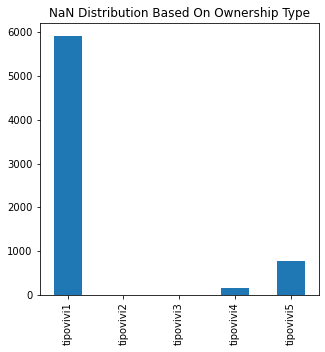

In [20]:
ownership_columns = ['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']
train_dataset.loc[train_dataset['v2a1'].isnull(), ownership_columns].sum().plot.bar(figsize=(5,5))
plt.title('NaN Distribution Based On Ownership Type')

Looking at the ablove analysis the NaNs will be replaced 0. We can safely replace all the Nan values of v2a1 with 0 for all those instances where tipovivi1=1, because the house is already paid for. The rest of the groups representation is very low and we will assume that the 0 replacement of the  other tipovivi groups shoud not have significant impact on the prediction model


In [21]:
#Replacing the v2a1's Nulls with 0
train_dataset['v2a1'].fillna(value=0, inplace=True)
print('Current Count Of Nulls In v2a1:',train_dataset['v2a1'].isnull().sum())

Current Count Of Nulls In v2a1: 0


#### v18q1 (Number of tablets household owns)

<AxesSubplot:>

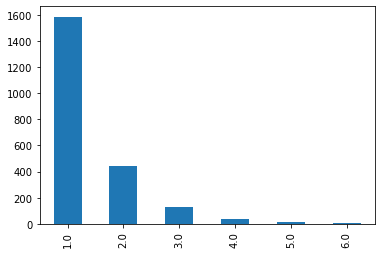

In [22]:
train_dataset['v18q1'].value_counts().sort_index().plot.bar()

Since v18q1 is a household levl column, let's compare the household Head's tablet's owned, v18q column shows this data, with number of nulls present in the v18q1 column

In [23]:
# Returns Number of nulls
def count_null(data):
    return data.isnull().sum()

In [24]:
Household_head = train_dataset[train_dataset['parentesco1']==1].copy()
Household_head.groupby('v18q')['v18q1'].apply(count_null)

v18q
0    2318
1       0
Name: v18q1, dtype: int64

From the above analysis, it is evident that there are 2318 NaN values for the Household heads whose 'Owns Tablet' value is 0 and none of the heads who owns a table has a NaN value in 'v18q1' column. With this, we can safely replace the NaN values with 0 meaning that the person doesn't hold any tablet.

In [25]:
# Replacing the v18q1's Nulls with 0

train_dataset['v18q1'].fillna(value=0, inplace=True)
print('Current Count Of Nulls In v18q1:',train_dataset['v18q1'].isnull().sum())

Current Count Of Nulls In v18q1: 0


#### 'rez_esc'[total nulls : 7928]: Years behind in school

The Years behind in school may be the measure of number of years a person is behind compared to the usual. So, the age of the person will be a good column for distribution analysis.

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64


<AxesSubplot:>

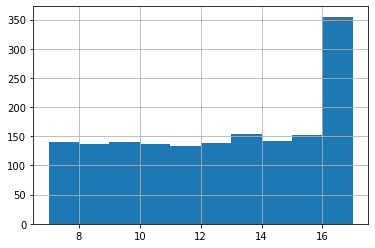

In [26]:
print(train_dataset.loc[(train_dataset['rez_esc'].notnull()) ,'age'].describe())
train_dataset.loc[train_dataset['rez_esc'].notnull(),'age'].hist()

This shows that the NOT Null values are mostly for the age group between 7 and 17 and this makes sense as well since years behind in scholl can be calculated for those who are actually in school.

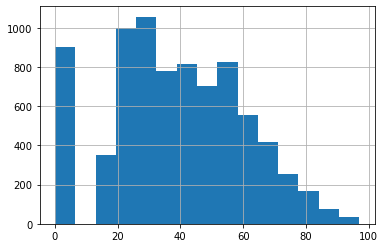

In [27]:
train_dataset.loc[(train_dataset['rez_esc'].isnull()) ,'age'].hist(bins=15)
plt.show()


In [28]:
# Number of instances that has a null and does fall withing the scooling years range
train_dataset.loc[(train_dataset['rez_esc'].isnull()) & ((train_dataset['age']>=7)&(train_dataset['age']<=17)),'age'].count()

1

#### From the above analysis we can replace the NaN with 0

In [29]:
train_dataset['rez_esc'].fillna(value=0, inplace=True)
print('Current Count Of Nulls In rez_esc:',train_dataset['rez_esc'].isnull().sum())

Current Count Of Nulls In rez_esc: 0


Similarly we can treat the remaining two columns which has 5 null instances each and can replace with 0

In [30]:
train_dataset['meaneduc'].fillna(value=0, inplace=True)
train_dataset['SQBmeaned'].fillna(value=0, inplace=True)
nulls_count = train_dataset.isnull().sum()
nulls_count[nulls_count>0]

Series([], dtype: int64)

The training dataset now doesn't contain any null values

###  Q3. Target Column Analysis (Check For Biases)

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64


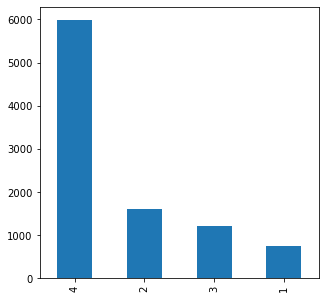

In [31]:
train_dataset['Target'].value_counts().plot.bar(figsize=(5,5))
print(train_dataset['Target'].value_counts())

#### This shows that there is an unequal output class distribution and our data is biased

### Household Level Analysis

### Q4 Check whether all members of the house have the same poverty level?
<b>1.</b> Group By household 'idhogar' column and see if all the members of the house has the same target value


In [32]:
target_variance_by_household = train_dataset.groupby('idhogar')['Target'].nunique()
print('There are {} households where all the members does not have unique target values'.format(sum(target_variance_by_household>1)))

There are 85 households where all the members does not have unique target values


Sample household with different targets

In [33]:
train_dataset.loc[train_dataset['idhogar']==target_variance_by_household[target_variance_by_household>2].index[0],['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
6023,5c6f32bbc,1,3
6024,5c6f32bbc,0,4
6025,5c6f32bbc,0,2


In [34]:
# Count of households count of different targets for the same household
target_variance_by_household.value_counts()

1    2903
2      84
3       1
Name: Target, dtype: int64

#### The above analysis shows that there are 2903 households which have unique target(all the members have consisten target mapping). 84 households have members that have 2 different targets and 1 household has 3 unique target values.

We will now target these 85 households and make the target value consisten with that of the head for that particular house. Before that we need to ensure if all the households have atleast 1 head.

### Q5. Check if there is a house without a family head?

In [35]:
households_with_target_variance = target_variance_by_household[target_variance_by_household>1].index
headless_households = []
headed_household = []
for house in target_variance_by_household.index:
    parentesco1sum = train_dataset.loc[train_dataset['idhogar']==house,'parentesco1'].sum()
    if parentesco1sum==0:
        headless_households.append(house)
    elif parentesco1sum ==1:
        headed_household.append(house)
print('There are {} households with no heads'.format(len(headless_households)))
print('There are {} households with heads'.format(len(headed_household)))

There are 15 households with no heads
There are 2973 households with heads


In [36]:
i=0
for headless in headless_households:
    for household in households_with_target_variance:
        if headless==household:
            i+=1
print('There are {} households with no head and have different Target value'.format(i))
        

There are 0 households with no head and have different Target value


### Q6. Set the poverty level of the members and the head of the house same in a family.

So, we can set the target value of all the members belonging to particular household to its head(parentesco1). Theare 85 such households

In [37]:
for hold in households_with_target_variance:
    train_dataset.loc[train_dataset['idhogar']==hold,'Target']= int(train_dataset.loc[(train_dataset['idhogar']==hold) & train_dataset['parentesco1']==1,'Target'])
    
target_variance_per_household = train_dataset.groupby('idhogar')['Target'].nunique()
print('Now, there are {} households where all the members does not have unique target values'.format(sum(target_variance_per_household>1)))

Now, there are 0 households where all the members does not have unique target values


### Dropping Unnecessary Columns

We should focus on the squared columns whihc might be redundant. Since we have a large number of columns and these squared columns might not be helpful

134. SQBescolari= escolari squared
135. SQBage, age squared
136. SQBhogar_total, hogar_total squared
137. SQBedjefe, edjefe squared
138. SQBhogar_nin, hogar_nin squared
139. SQBovercrowding, overcrowding squared
140. SQBdependency, dependency squared
141. SQBmeaned, square of the mean years of education of adults (>=18) in the
household
142. agesq= Age squared

In [38]:
drop_columns = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']
print('Shape of training set before dropping squared columns',train_dataset.shape)
train_dataset.drop(columns= drop_columns, inplace=True)
print('Shape of training set after dropping squared columns',train_dataset.shape)

Shape of training set before dropping squared columns (9557, 143)
Shape of training set after dropping squared columns (9557, 134)


### Q8. Remove null value rows of the target variable.

In [39]:
train_dataset['Target'].isnull().sum()

0

#### Segregating the Household and Individual Level Variables for Further Reduction in Dimensionality

In [40]:
id_cols = ['Id', 'idhogar', 'Target'] # identity & Target columns

# Individual boolean variables
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone']

# Individual Ordered variables
ind_ord = ['rez_esc', 'escolari', 'age']

# Household boolean

house_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2']

# Household ordered

house_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

# Household continuous
house_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

### Household Level Analysis

In [41]:
house_cols = id_cols + house_bool + house_ordered + house_cont
house_train_dataset = train_dataset.loc[train_dataset['parentesco1']==1,house_cols]
house_train_dataset.shape

(2973, 98)

#### Formulate the correlation matrix to see if there is any strong coorelation between the variables

we will be using the numpy's triu function inorder to just get upper triangle of the correlation matrix.
A correlation matrix is an nXn matrix where n is the number of dependant variables and each value in the cell is the correlation between its row index variable and column index variable. Also, the diagonal value of such a matrix is 1, since the diagonal value is the correlation between itself.

In [42]:
house_train_dataset_corr = house_train_dataset.corr()               # corr matrix
house_train_dataset_corr_shape = house_train_dataset_corr.shape     # shape of correlation matrix
true_bools = np.ones(house_train_dataset_corr_shape).astype(bool)   # True boolean matrix of shape mXn (shape as above) 
upper_tri_bools = np.triu(true_bools,k=1)                           # k=1 excludes the diagonal values as well
upper_house_train_dataset_corr = house_train_dataset_corr.where(upper_tri_bools) #Where cond is True, keep the original value
household_col_to_drop = [column for column in upper_house_train_dataset_corr.columns 
                         if any(abs(upper_house_train_dataset_corr[column])>0.95)]
household_col_to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

#### Higly correlated Columns

'coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total'

<b>coopele</b> : =1 electricity from cooperative
<br>
<b>area2</b> : =2  zona rural
<br>
<b>tamhog</b> : size of the household
<br>
<b>hhsize</b> : household size
<br>
<b>hogar_total</b> : # of total individuals in the household
<br>

We need to check what are the other substitute columns for each one above one by one

#### Coopele

In [43]:
# coopele correlation data
coopele_corr_data = house_train_dataset_corr.loc['coopele']
coopele_corr_data[abs(coopele_corr_data)>.95]

public    -0.974788
coopele    1.000000
Name: coopele, dtype: float64

From above, we can see that the 'public' variable is showing strong negative coorelation with the 'coopele'

In the document the 'public' variable's definition is '=1 electricity from CNFL, ICE, ESPH/JASEC'. We can drop one of them however we will be keeping this for now considering the difference in their representation

#### area2

In [44]:
# area2 correlation data
area2_corr_data = house_train_dataset_corr.loc['area2']
area2_corr_data[abs(area2_corr_data)>.95]

area1   -1.0
area2    1.0
Name: area2, dtype: float64

This shows area1(1 zona urbana) and area 2 are negatively coorealted. We can drop one of the columns

#### tamhog

There are several columns representing the same measure that of Tamhog. Let's explore further

In [45]:
tamhog_corr_data = house_train_dataset_corr.loc[abs(house_train_dataset_corr['tamhog'])>0.9
                                                ,abs(house_train_dataset_corr['tamhog'])>0.9]
tamhog_corr_data

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.996884,0.929237,0.996884,0.996884
tamhog,0.996884,1.000000,0.926667,1.000000,1.000000
tamviv,0.929237,0.926667,1.000000,0.926667,0.926667
hhsize,0.996884,1.000000,0.926667,1.000000,1.000000
hogar_total,0.996884,1.000000,0.926667,1.000000,1.000000


The above correlation matrix is a subset of the main correlation matrix and shows all the correlaed fields of Tamhog. The definition of each one is as below and all of them represent the total size of the household. we can choose to keep only one of them.

<b>tamhog</b> : size of the household
<br>
<b>hhsize</b> : household size
<br>
<b>hogar_total</b> : # of total individuals in the household
<br>
<b>tamviv</b> : number of persons living in the household
<br>
<b>r4t3</b> : Total persons in the household
<br>


### Individual Level Analysis

In [46]:
individual_cols = id_cols + ind_bool + ind_ord
ind_train_dataset = train_dataset[individual_cols]
ind_train_dataset.shape

(9557, 39)

In [47]:
# correlation matrix
individual_cols_corr = train_dataset[individual_cols].corr()
individual_cols_corr_shape = individual_cols_corr.shape
ind_true_bool = np.ones(individual_cols_corr_shape).astype(bool)
ind_upper_tri_bool = np.triu(ind_true_bool, k=1)
ind_upper_tri_corr = individual_cols_corr.where(ind_upper_tri_bool)
ind_cols_to_drop = [column for column in ind_upper_tri_corr.columns if any(abs(ind_upper_tri_corr[column])>0.95)]
ind_cols_to_drop

['female']

#### The 'female' colum is show some strong correlation with another dependant variable.

In [48]:
female_data_corr = individual_cols_corr.loc['female']
female_data_corr[abs(female_data_corr)>0.95]

male     -1.0
female    1.0
Name: female, dtype: float64

As evident above, the female column is strongly correlated with the male variable. We can choose to keep only one

#### Final Drop List

We will be deleting 'area2', 'female'(keeping male),'tamhog'(keeping hh size), 'hogar_total', 'r4t3'(keeping tamviv). Also we will now drop the id columns id, idhogar.

In [49]:
final_drop_col = ['area2', 'female','tamhog', 'hogar_total', 'r4t3', 'Id', 'idhogar']

train_dataset.drop(columns=final_drop_col, inplace=True)
train_dataset.shape


(9557, 127)

## Model Training

#### Data splitting

In [50]:
from sklearn.model_selection import train_test_split

X = train_dataset.iloc[:,:-1]
y = train_dataset.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [51]:
shapes = shapes= [X_train.shape,y_train.shape, X_test.shape,y_test.shape]
shapes

[(7645, 126), (7645,), (1912, 126), (1912,)]

In [52]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(#max_leaf_nodes = 32,
                                     n_estimators=100,
                                     oob_score = True,
                                     n_jobs = -1,
                                     criterion = 'gini')

print(RF_classifier)

RandomForestClassifier(n_jobs=-1, oob_score=True)


In [53]:
from sklearn import metrics

In [54]:
RF_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
RF_classifier.fit(X_train, y_train)
y_pred_rf = RF_classifier.predict(X_test)

print('Random Forest R2 Score', metrics.r2_score(y_train,RF_classifier.predict(X_train)))
print('Random Forest OOB Score',RF_classifier.oob_score_ )



Random Forest R2 Score 1.0
Random Forest OOB Score 0.937737083060824


#### Feature Importances

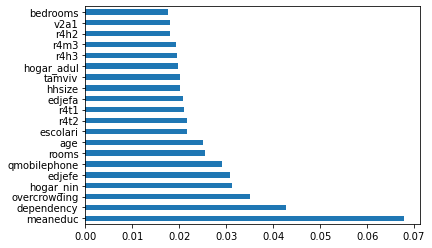

In [56]:
features = pd.Series(RF_classifier.feature_importances_, index=X_train.columns)
features.nlargest(20).plot(kind='barh')
plt.show()

#### meanedu, dependency & overcrowding seem to be important predictors for the model along with other.

### Q9. Predict the accuracy using random forest classifier?
#### Prediction Accuracy

In [57]:
print(metrics.classification_report(y_test, y_pred_rf))
print(metrics.confusion_matrix(y_test, y_pred_rf))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, y_pred_rf, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           1       0.99      0.90      0.94       169
           2       0.97      0.88      0.93       302
           3       0.99      0.81      0.89       257
           4       0.93      1.00      0.96      1184

    accuracy                           0.94      1912
   macro avg       0.97      0.90      0.93      1912
weighted avg       0.95      0.94      0.94      1912

[[ 152    2    0   15]
 [   2  266    1   33]
 [   0    1  209   47]
 [   0    4    1 1179]]
Accuracy of the model on Testing Sample Data: 0.94


### Q10. Check the accuracy using a random forest with cross-validation?
#### K Fold Cross Validation

In [58]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
RF_classifier_kfold = RandomForestClassifier(n_estimators=100,
                                            n_jobs = -1, random_state=10
                                            )
RF_classifier_kfold.fit(X_train,y_train)
Accuracy_Values=cross_val_score(RF_classifier_kfold, X , y, cv=kfold, scoring='accuracy')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean()*100,2))


Accuracy values for 10-fold Cross Validation:
 [0.94508368 0.94142259 0.93772894 0.9466248  0.9544741 ]

Final Average Accuracy of the model: 94.51


## Test Data Cleaning and Prediction

In [60]:
test_dataset = pd.read_csv('test.csv')

In [61]:
mapping = {'no':0,'yes':1}

# edjefe, edjefa, dependancy

test_dataset['edjefe'] = test_dataset['edjefe'].replace(mapping)
test_dataset['edjefa'] = test_dataset['edjefa'].replace(mapping)
test_dataset['dependency'] = test_dataset['dependency'].replace(mapping).astype(np.float64)



Text(0.5, 1.0, 'NaN Test Distribution Based On Ownership Type')

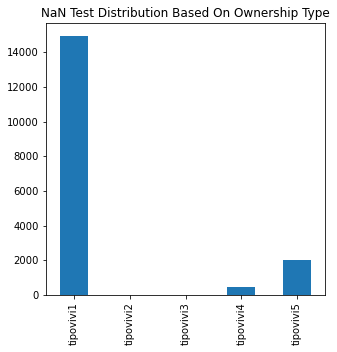

In [62]:
#ownership_columns = ['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']
test_dataset.loc[test_dataset['v2a1'].isnull(), ownership_columns].sum().plot.bar(figsize=(5,5))
plt.title('NaN Test Distribution Based On Ownership Type')

#### Null Value Replacement

In [63]:
# Replacing Null values
test_dataset['v2a1'].fillna(value=0, inplace=True)
test_dataset['v18q1'].fillna(value=0, inplace=True)
test_dataset['rez_esc'].fillna(value=0, inplace=True)
test_dataset['meaneduc'].fillna(value=0, inplace=True)
test_dataset['SQBmeaned'].fillna(value=0, inplace=True)
test_nulls_count = test_dataset.isnull().sum()
test_nulls_count[test_nulls_count>0]


Series([], dtype: int64)

#### Dropping Test columns based on our analysis of Training Data

In [64]:
test_drop_columns = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                    'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
                     'agesq','area2', 'female','tamhog', 'hogar_total', 'r4t3', 'Id', 'idhogar']
test_dataset.drop(columns=test_drop_columns, inplace=True)
test_dataset.shape

(23856, 126)

#### Prediction On Test Data

In [65]:
# K Fold model prediction
test_data_prediction_kfold = RF_classifier_kfold.predict(test_dataset)
test_data_prediction_kfold

array([4, 4, 4, ..., 4, 4, 2], dtype=int64)